In [1]:
from fastai.vision.widgets import *
from ipywidgets import interact
from fastai.basics import *
from fastbook import *
import warnings
import timm

# Código para ignorar avisos de usuário
warnings.filterwarnings("ignore", category=UserWarning)

# Artigo 3

## 1. Introdução

A aula 3 explora outros modelos pré-treinados, e como decidir qual o mais apropriado para cada situação, mas seu foco principal é em explicar como as redes neurais funcionam do nível mais baixo até a sua implementação pelo *fastai*.

## 2. Objetivo

Simular uma rede neural com funções quadráticas e retificadoras, comparar o modelo `resnet18` com o `convnext_tiny` e subir um classificador de imagens para o Hugging Face.

## 3. Inspiração

Adquirir um entendimento de como redes neurais são capazes de "aprendizado", e verificar a efetividade de outros modelos de imagem no treinamento de um modelo classificador de raças de cavalo. 

## 4. Diferentes modelos

Um dos assuntos abordados na lição 3 foi a existência de outros modelos de imagem pré-treinados que podem ser usados no treinamento de nosso modelo.

No caderno do Kaggle [Which image models are best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best/) podemos ver vários modelos na forma de um gráfico, com o eixo X sendo o tempo gasto para treinar e o eixo Y sendo a precisão.

<p allign="middle">
  <img src="assets/resnet.png" width="418" />
  <img src="assets/conv.png" width="400" /> 
</p>

Acima vemos o model o usado até agora (resnet18), e um modelo utilizado na lição 3 (convnext_tiny), que apesar de ser um pouco mais lento, possui uma precisão bem maior.

Para testar a diferença em eficácia do `resnet18` para o `convnext_tiny`, vamos treinar um modelo usando ambos.  
O dataset utilizado foi o [Horse Breeds](https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds), criado por Olga Belitskaya no Kaggle.

In [2]:
path = Path('img')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

O parâmetro `bs` passado para o `dataloader` determina o tamanho do batch, que por padrão é 64, e aqui foi reduzido para 32 para evitar problemas de falta de memória. 

In [3]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.848371,1.130055,0.404762,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.792139,0.593737,0.238095,00:03
1,0.543827,0.202370,0.083333,00:02
2,0.428140,0.128498,0.047619,00:02
3,0.371214,0.126295,0.059524,00:02


Utilizando o `resnet18` a taxa de erro final foi de 5,9%, com o menor valor atingido sendo 4,7%, e a duração das épocas foi de 2 segundos.  

A seguir podemos utilizar o método `list_models()` para listar os modelos presentes na biblioteca `timm` que possuem `convnext` em seu nome.

In [6]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

O modelo que vamos utilizar é o `convnext_tiny_in22k`, e seu nome deve ser passado como string, pois não está presente no fastai e será baixado antes de poder ser utilizado.

In [3]:
learn2 = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate)
learn2.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.551015,0.408585,0.142857,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.391352,0.131678,0.059524,00:25
1,0.273580,0.063855,0.023810,00:25
2,0.203980,0.052625,0.023810,00:25
3,0.179815,0.047770,0.023810,00:25


Como podemos ver, a taxa de erro foi de 2,3% e a duração de cada época foi de 25 segundos.

Portanto concluímos que apesar de demorar 15 vezes mais para cada época, o `convnext_tiny` gerou uma taxa de erro 2 vezes menor, e considerando que 25 segundos não é tanto tempo assim, seu uso é definitivamente vantajoso nessa aplicação.

Vamos então exportar o modelo e criar uma aplicação no HuggingFace.

In [4]:
learn2.export('modelo.pkl')

E utilizando o seguinte `app.py`:

```python
from fastai.vision.all import *
import gradio as gr

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

learn = load_learner('modelo.pkl')
categories = ('Akhal-Teke', 'Appaloosa', 'Arabian', 'Friesian')

image = gr.Image(shape=(192,192))
label = gr.Label()
examples = ['img/d.jpg', 'img/m.jpg', 'img/r.jpg', 'img/t.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)
```

Aplicação online no seguinte [link](https://huggingface.co/spaces/vnsrz/cavalos).

<img src="assets/face.png" alt="" width="500" /><br>

##  5. Redes neurais e seu funcionamento

### 5.1 *Gradient descent*

Uma rede neural nada mais é do que uma função matemática. Em uma rede neural típica, a função:
1. Multiplica cada entrada por um conjunto de valores. Esses valores são chamados de *parâmetros*
2. Os soma para cada grupo de valores
3. Substitui os valores negativos por 0

Esse processo representa uma *camada*. Esses passos são então repetidos, usando a saída da camada anterior como entrada da próxima. 

Os parâmetros inicias são aleatórios, então para a função ser capaz de aprender algo útil, devemos melhorar os parâmetros de alguma forma, é aí que entra o **método do gradiente** (*gradient descent*).

In [5]:
plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

Para explorar a matemática por trás das redes neurais de forma interativa, serão usadas algumas bibliotecas e funções do Python.

Para aprender sobre *gradient descent*, vamos começar com uma função quadrática:

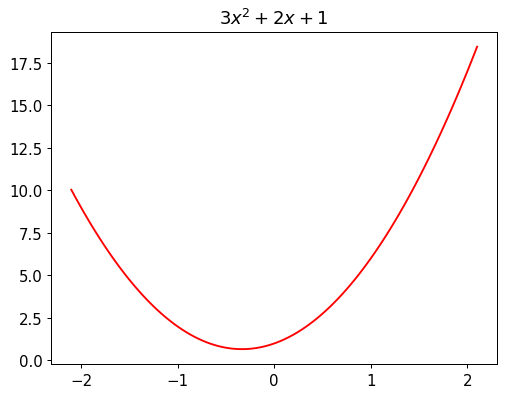

In [6]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

Nossa função quadrática tem 3 parâmetros: $a=3$, $b=2$, $c=1$. Podemos criar uma função para calcular o valor do ponto em qualquer quadrática, e então outra função para fixar os valores de `a, b, c` que passarmos:

In [7]:
def quad(a,b,c,x): return a*x**2 + b*x + c
def mk_quad(a,b,c): return partial(quad, a,b,c)

Pronto, agora podemos criar qualquer quadrática facilmente.
Podemos então simular ruído nas medidas da função `f`, e usar o *gradient descent* para tentar recriar a função original.

In [8]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

A função `np.random.normal()` pega amostras aleatórias de uma distribuição normal (Gaussiana)
Então realizamos os 3 passos para criar uma camada através da função `add_noise()`.

In [9]:
np.random.seed(42)
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

A função `torch.linspace(start, end, steps)` cria um *tensor* unidimensional que começa em `start`, termina em `end`, e é dividido em espaços iguais na quantidade de `steps`.

Um *tensor* pode ser um único número (tensor rank 0), uma lista de números (tensor rank 1), uma tabela de números (tensor rank 2), uma tabela de tabelas de números (tensor rank 3), e etc.

Podemos fazer um *scatter plot* para visualizar nossos dados:

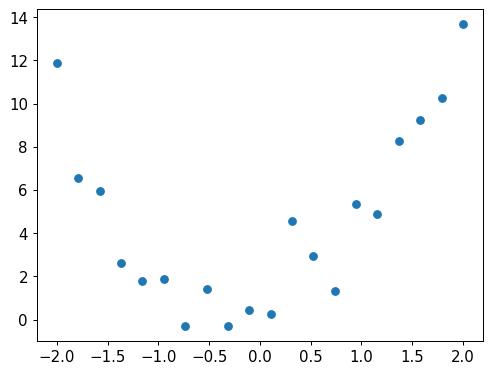

In [10]:
plt.scatter(x,y);

Como encontrar os valores de `a, b, c` que se encaixam nos dados? Uma alternativa é alterá-los manualmente.

In [11]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Ajustando os valores, a melhor combinação que encontrei foi:

$a=2.60$<br>
$b=1.40$<br>
$c=0.90$<br>

Uma desvantagem desse método é que temos que nos basear em nosso julgamento se o *fit* da função está melhorando ou piorando com cada alteração, mas podemos adicionar um valor numérico para nos basearmos, o **erro médio absoluto**, que é a distância de cada ponto para a curva.

In [12]:
def ema(preds, acts): return (torch.abs(preds-acts)).mean()

In [13]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"EMA: {loss:.2f}")

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

Através do EMA, o melhor conjunto de valores foi:

$a=2.10$<br>
$b=1.30$<br>
$c=2.10$<br>

Uma rede neural moderna tem milhões de parâmetros para ajustar, e milhares de pontos de dados. Não é possível realizar tudo isso à mão, mas podemos automatizar o processo.

### 5.2 Automatização

A ideia é saber o efeito da alteração de cada parâmetro no EMA, então encontramos o gradiente do EMA para cada parâmetro, e os ajustamos na direção oposta.

In [14]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

Essa função calcula o EMA pra um conjunto de valores qualquer, então podemos selecionar um conjunto de valores de `a,b,c` para colocar em um tensor, e em seguida explicitar ao PyTorch que vamos calcular gradientes para cada parâmetro:

In [15]:
abc = torch.tensor([1.1, 1.1, 1.1])
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

Podemos então calcular o EMA. Geralmente no *gradient descent* a coisa minimizada é chamada de perda (*loss*).

In [16]:
loss = quad_mae(abc)
loss

TensorBase(2.4219, grad_fn=<AliasBackward0>)

Vamos calcular os gradientes através da função `backward()`, e eles ficam guardados na variável `grad`.

In [17]:
loss.backward()
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

De acordo com os gradientes devemos aumentar os parâmetros, então podemos subtrair o gradiente multiplicado por um número pequeno para atingir o resultado desejado:

In [18]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)
    
print(f'loss={loss:.2f}')

loss=2.40


O pequeno número utilizado na multiplicação é chamado de *taxa de aprendizado*, e é crucial no treinamento de uma rede neural.

Podemos repetir o processo para reduzir mais o erro: 

In [19]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


Eventualmente o valor do erro vai começar a subir, pois os valores dos parâmetros vão superar os corretos. Para isso precisamos diminuir a taxa de aprendizado enquanto treinamos. Isso é feito usando uma *rotina de taxa de aprendizado*, e pode ser automatizada pelo seu framework, como o fastai.

### 5.3 Retificadores

Redes neurais são muito mais complexas do que nosso exemplo, porque são capazes de aproximar qualquer função computável desde que possuam parâmetros o suficiente. Isso as torna capazes de entender e traduzir a fala humana, pintar um quadro, escrever uma redação, e muito mais.

Para aproximar uma função precisamos combinar dois passos:
1. Multiplicação de matrizes
2. A função `max(x,0)`, que troca todos números negativos para 0

No PyTorch, a função equivalente à `max(x,0)` é a `np.clip(x,0)`.  
A combinação desses passos se chama *função retificada linear* e sua implementação é a seguinte:

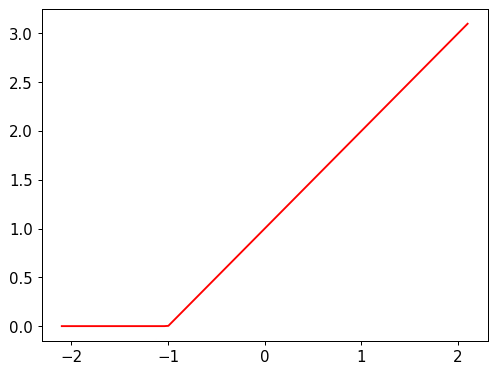

In [20]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

plot_function(partial(rectified_linear, 1,1))

Sozinha a função não faz muito, mas quando somamos duas:

In [21]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

É possível perceber que com uma quantidade suficiente de funções somadas, seríamos capazes de aproximar qualquer função com uma única entrada.

Portanto, a diferença entre os experimentos realizados aqui e uma rede neural funcional é a quantidade de tempo e dados fornecidos.

## 6. Conclusão

A resnet18 é uma excelente ferramenta para treinar um modelo rapidamente, mas existem vários modelos de imagem que possuem uma acurácia maior, e vale a pena experimentar com alguns deles antes da decisão final.

Redes neurais é um assunto complexo, mas pode ser quebrado em passos pequenos, assim se tornando compreensível.